In [1]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from training import train, create_training_folder, create_callbacks, step_decay_exp


from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import concatenate, Embedding, LSTM, BatchNormalization, Dense, \
    Conv1D, GlobalAveragePooling1D, Dropout, Input, Permute, Concatenate, GlobalMaxPooling1D, MaxPooling1D, \
    Flatten, Activation, Reshape,SpatialDropout1D, Add, MaxPooling1D, Masking, Lambda


from training import train, create_training_folder


Using TensorFlow backend.


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
# model = tf.keras.models.load_model('/home/gus/workspaces/wpy/IACapstone/results/tcn/20200802_085010_64/model')

In [4]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [5]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 3:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
y = to_categorical(y)
# random train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# y_train = to_categorical(y_train, num_classes=vocab_size)
# y_test = to_categorical(y_test, num_classes=vocab_size)

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [6]:
X.shape

(31373, 8)

In [7]:
crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

In [8]:
np.unique(X)
np.unique(y)

df_crops

# model = load_model('../results/20200719_181629_lstm_64_64')


,code,description,is_crop,idx
0,1,TRIGO,1,0
1,3,URBANO-VIALES,0,1
2,4,MAIZ,1,2
3,5,CEBADA,1,3
4,8,OTROS CEREALES,1,4
5,9,ROQUEDOS,0,5
6,20,SUELO DESNUDO,1,6
7,33,GIRASOL,1,7
8,35,COLZA,1,8
9,39,OTRAS LEGUMINOSAS GRANO,1,9


In [9]:
# y_pred = model.predict(X_test)

# class_test = np.argmax(y_test, axis=1)
# class_predicted = np.argmax(y_pred,crop_names axis=1)

# # eval_model(folder, class_predicted, class_test, classes, labels)
# np.unique(class_predicted)

In [10]:

def inception(input):
    conv1 = Conv1D(32, 2, padding='same', activation="relu")(input)
    conv2 = Conv1D(32, 3, padding='same', activation="relu")(input)
    conv3 = Conv1D(32, 5, padding='same', activation="relu")(input)

#     pool = MaxPooling1D(2, strides=1, padding='same')(input)
#     conv4 = Conv1D(32, 1, padding='same')(pool)

    output = Add()([conv1, conv2, conv3])
    output = SpatialDropout1D(0.3)(output)
    return output

def lstm_subseq(input, seq):
    conv1 = Conv1D(32, 2, padding='same', activation="relu")(input)
    conv2 = Conv1D(32, 3, padding='same', activation="relu")(input)
    conv3 = Conv1D(32, 5, padding='same', activation="relu")(input)

#     pool = MaxPooling1D(2, strides=1, padding='same')(input)
#     conv4 = Conv1D(32, 1, padding='same')(pool)

    output = Add()([conv1, conv2, conv3])
    output = SpatialDropout1D(0.3)(output)
    return output

def lstm_inception(sequence_length, embeddings, layer_size=64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    conv_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    
    x = inception(conv_emb)
    x = inception(x)
    x = inception(x)
    x = inception(x)

    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Activation('relu')(x)

    x = LSTM(units=256, recurrent_dropout=0.4, dropout=0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Flatten()(x)

    output = Dense(vocab_size, activation='relu')(x)
    
    return Model(input, output)
    

def multi_lstm(sequence_length, embeddings, layer_size=64):
    vocab_size, embedding_size = embeddings

    input = Input(shape=(sequence_length,))

    conv_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    
    x = inception(conv_emb)
    x = inception(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.3)(x)


    lstm_emb = Embedding(vocab_size, embedding_size, input_length=sequence_length)(input)
    lstm = SpatialDropout1D(0.3)(lstm_emb)
    lstm = LSTM(units=64, recurrent_dropout=0.3, return_sequences=True)(lstm)
    
    x = Concatenate()([x, lstm])
#     x = BatchNormalization()(x)
#     x = Activation(activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Activation('relu')(x)

    lstm0 = LSTM(units=64, recurrent_dropout=0.3)(x)
    
    lstm1 = Lambda(lambda x: x[:, -3:, :])(lstm)
    lstm1 = LSTM(units=64, recurrent_dropout=0.3)(x)
    
    lstm2 = Lambda(lambda x: x[:, -5:,:])(lstm)
    lstm2 = LSTM(units=64, recurrent_dropout=0.3)(x)

    
    x = Concatenate()([lstm0, lstm1, lstm2])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Activation(activation='relu')(x)
    
    x = Flatten()(x)

    output = Dense(vocab_size, activation='relu')(x)
    
    return Model(input, output)
    

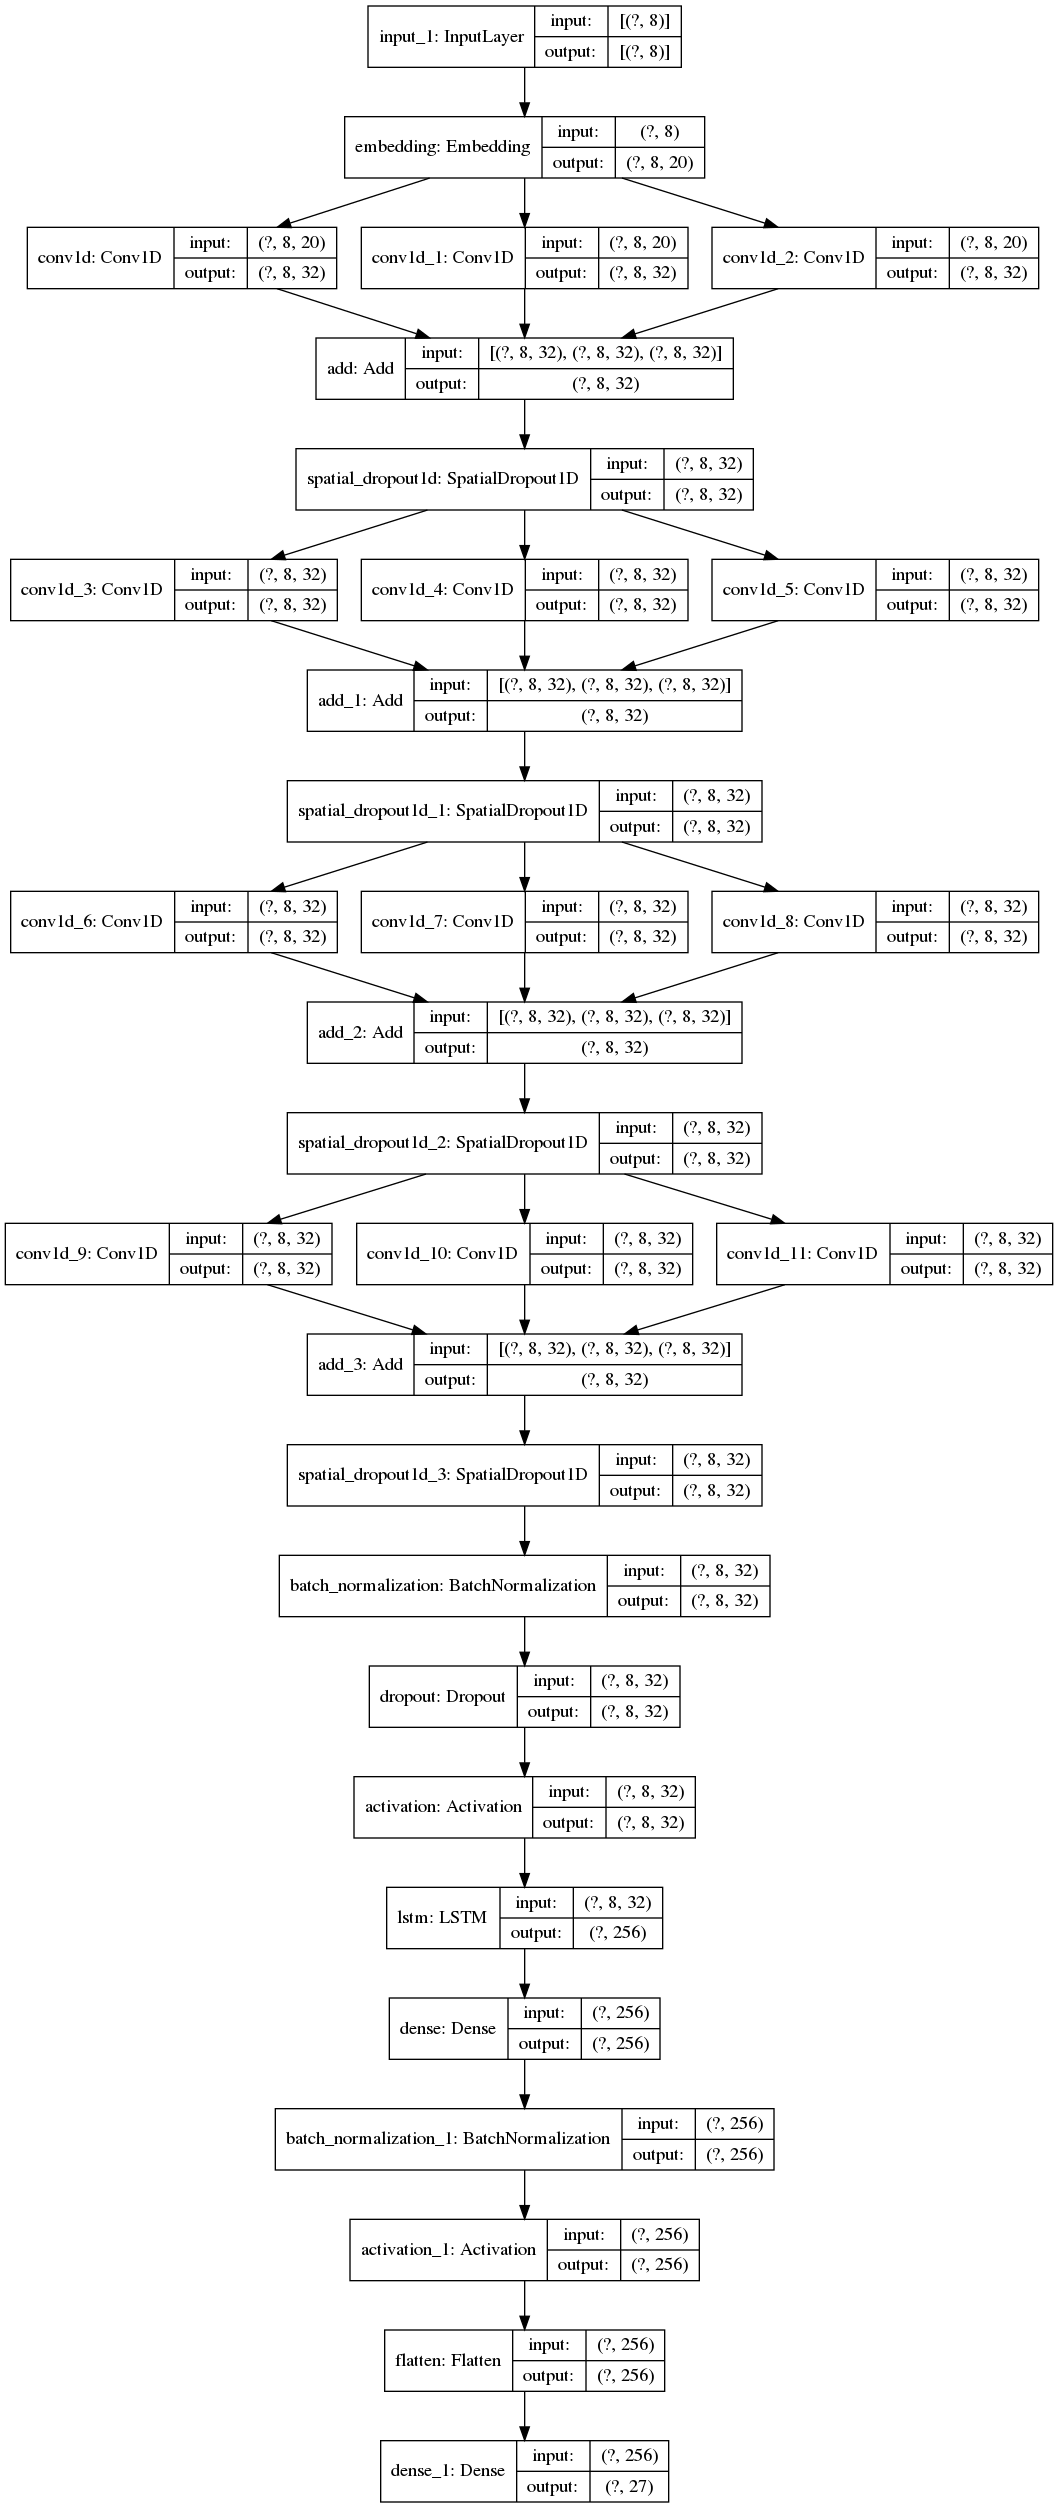

In [11]:

# K.clear_session()
sequence_length = 8
vocab_size, embedding_size = (27, 20)
# model = hydrid(sequence_length, (vocab_size, embedding_size))
model = lstm_inception(sequence_length, (vocab_size, embedding_size))

tag = "conv_rest_stacked"

tf.keras.utils.plot_model(model, show_shapes = True)

In [12]:


# sequence_length = 8

# vocab_size, embedding_size = (28, 5)
# layer_size = (64, 32)
# final_activation = "relu"

# model = Sequential()
# model.add(Embedding(vocab_size, embedding_size,
#                     input_length=sequence_length))
# return_sequences = True
# for i, units in enumerate(layer_size):
#     if i == len(layer_size) - 1:  # last layer
#         return_sequences = False
#     model.add(LSTM(units, dropout=0.3, recurrent_dropout=0.4,
#                    activation='relu', return_sequences=return_sequences))
# model.add(BatchNormalization())
# model.add(Dense(vocab_size, activation=final_activation))
# tag = "conv_lstm_128_64"

In [13]:
# tf.keras.backend.clear_session()

training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=100
exp_base = "conv1d"
folder = create_training_folder(exp_base, tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)


Epoch 1/100

Epoch 00001: val_f1 improved from -inf to 0.33804, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked/assets
687/687 - 25s - loss: 0.7502 - f1: 0.2501 - val_loss: 0.6610 - val_f1: 0.3380
Epoch 2/100

Epoch 00002: val_f1 did not improve from 0.33804
687/687 - 20s - loss: 0.6409 - f1: 0.3592 - val_loss: 0.6613 - val_f1: 0.3376
Epoch 3/100

Epoch 00003: val_f1 improved from 0.33804 to 0.38996, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked/assets
687/687 - 24s - loss: 0.6065 - f1: 0.3933 - val_loss: 0.6091 - val_f1: 0.3900
Epoch 4/100

Epoch 00004: val_f1 imp

Epoch 28/100

Epoch 00028: val_f1 improved from 0.65332 to 0.65664, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked/assets
687/687 - 24s - loss: 0.3492 - f1: 0.6504 - val_loss: 0.3417 - val_f1: 0.6566
Epoch 29/100

Epoch 00029: val_f1 did not improve from 0.65664
687/687 - 20s - loss: 0.3405 - f1: 0.6590 - val_loss: 0.3451 - val_f1: 0.6530
Epoch 30/100

Epoch 00030: val_f1 improved from 0.65664 to 0.66896, saving model to /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/conv1d/20200809_210404_conv_rest_stacked/assets
687/687 - 24s - loss: 0.3386 - f1: 0.6609 - val_loss: 0.3291 - val_f1: 0.6690
Epoch 31/100

Epoch 00031: val_f1 did not improve from 0.66896
687/687 - 20s - loss: 0.3482 - f1: 0.6512 - val_

687/687 - 24s - loss: 0.3109 - f1: 0.6884 - val_loss: 0.3169 - val_f1: 0.6811
Epoch 69/100

Epoch 00069: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3100 - f1: 0.6895 - val_loss: 0.3179 - val_f1: 0.6804
Epoch 70/100

Epoch 00070: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3122 - f1: 0.6873 - val_loss: 0.3217 - val_f1: 0.6765
Epoch 71/100

Epoch 00071: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3149 - f1: 0.6847 - val_loss: 0.3232 - val_f1: 0.6749
Epoch 72/100

Epoch 00072: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3114 - f1: 0.6880 - val_loss: 0.3197 - val_f1: 0.6784
Epoch 73/100

Epoch 00073: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3045 - f1: 0.6951 - val_loss: 0.3177 - val_f1: 0.6802
Epoch 74/100

Epoch 00074: val_f1 did not improve from 0.68115
687/687 - 20s - loss: 0.3081 - f1: 0.6913 - val_loss: 0.3220 - val_f1: 0.6762
Epoch 75/100

Epoch 00075: val_f1 did not improve from 0.68115
687/687 - 20s

In [36]:

# evaluate
y_hat = model.predict(X_test)
# eval_model_one_hot(folder, y_test, y_hat, crop_list, crop_names)
print(y_hat[99])

print(y_test[99])


[  0.       0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.       0.       0.       0.       0.       0.
 618.4512   0.       0.       0.       0.       0.       0.       0.
   0.       0.       0.    ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
